## Part 2

In [1]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.7 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=5034ecc3796aa2dec109c55a53c0f6141c5a6cf991cf6a48ee7a04e03b150782
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [1]:
import wandb
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torch.utils.data import random_split
#import jovian

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/HW02-Practical

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/HW02-Practical


In [3]:
TRAIN_DIR = "Dataset/train"
VAL_DIR = "Dataset/valid"

In [4]:
transform_ds = T.Compose([
    T.Resize((128, 128)),
    T.RandomHorizontalFlip(),
    T.ToTensor()
])

train_ds = torchvision.datasets.ImageFolder(root=TRAIN_DIR,
                                           transform=transform_ds)

In [5]:
num_classes= len(train_ds.classes)
num_classes

5

In [6]:
val_ds = torchvision.datasets.ImageFolder(root=VAL_DIR,transform=transform_ds)

In [7]:
batch_size= 512

In [8]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
def show_images(train_dl):
    for images, labels in train_dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=8).permute(1,2,0))
        break

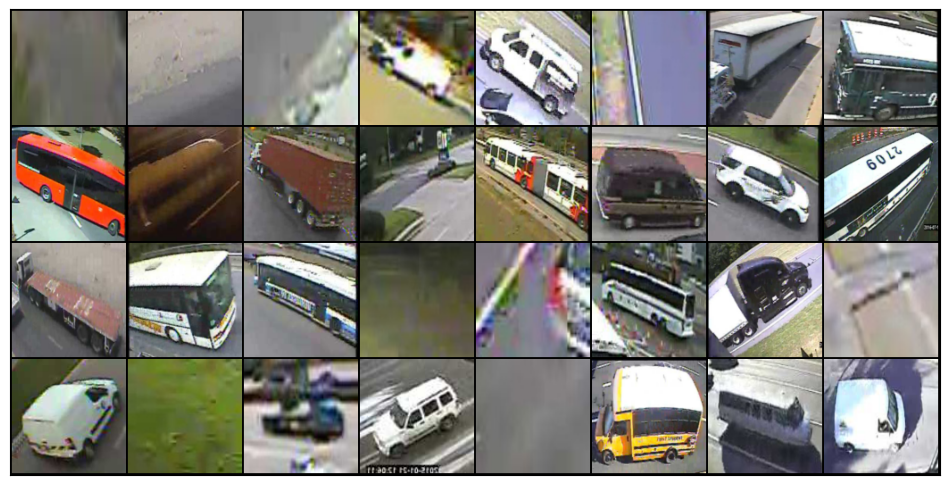

In [11]:
show_images(train_dl)

In [10]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")
    
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)
            
    def __len__(self):
        return len(self.dl)

In [11]:
device = get_device()
device

device(type='cuda')

In [12]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [13]:
def accuracy(out, labels):
    _, preds = torch.max(out, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [14]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {"val_loss": loss.detach(), "val_acc": acc}
    
    def validation_epoch_end(self, outputs):
        batch_loss = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}
    
    def epoch_end(self, epoch, epochs, result):
        print("Epoch: [{}/{}], last_lr: {:.6f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch+1, epochs, result["lrs"][-1], result["train_loss"], result["val_loss"], result["val_acc"]))

In [15]:
class model(ImageClassificationBase):
     def __init__(self, num_classes):
         super().__init__()
         self.network = models.resnet18(pretrained=True)
         number_of_features = self.network.fc.in_features
         self.network.fc = nn.Linear(number_of_features, num_classes)
        
     def forward(self, xb):
         return self.network(xb)
    
     def freeze(self):
         for param in self.network.parameters():
             param.requires_grad= False
         for param in self.network.fc.parameters():
             param.requires_grad= True
        
     def unfreeze(self):
         for param in self.network.parameters():
            param.requires_grad= True


In [16]:
model = to_device(model(num_classes), device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
@torch.no_grad()
def evaluate(model, val_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_dl]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]
    
def fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, weight_decay=0, grad_clip=None,
                 opt_func=torch.optim.Adam):
    
    torch.cuda.empty_cache()
    
    history = []
    opt = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr, epochs=epochs,
                                                   steps_per_epoch=len(train_dl))
    
    for epoch in range(epochs):
        model.train()
        train_loss = []
        lrs = []
        for batch in tqdm(train_dl):
            loss = model.training_step(batch)
            train_loss.append(loss)
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            opt.step()
            opt.zero_grad()
            
            lrs.append(get_lr(opt))
            sched.step()
            
        result = evaluate(model, val_dl)
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["lrs"] = lrs
        model.epoch_end(epoch, epochs, result)
        history.append(result)
    return history

In [18]:
epochs = 7
max_lr = 10e-5
grad_clip = 0.1
weight_decay = 10e-4
opt_func=torch.optim.Adam

In [19]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 1.8116768598556519, 'val_acc': 0.19062499701976776}]

In [20]:
model.unfreeze()

In [21]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, weight_decay=weight_decay,grad_clip=grad_clip, opt_func=opt_func)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: [1/7], last_lr: 0.000047, train_loss: 1.3681, val_loss: 0.9412, val_acc: 0.6825


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: [2/7], last_lr: 0.000099, train_loss: 0.4052, val_loss: 0.3486, val_acc: 0.8740


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: [3/7], last_lr: 0.000092, train_loss: 0.1503, val_loss: 0.2609, val_acc: 0.9104


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: [4/7], last_lr: 0.000067, train_loss: 0.0789, val_loss: 0.2407, val_acc: 0.9141


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: [5/7], last_lr: 0.000036, train_loss: 0.0446, val_loss: 0.2302, val_acc: 0.9197


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: [6/7], last_lr: 0.000010, train_loss: 0.0317, val_loss: 0.2182, val_acc: 0.9269


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: [7/7], last_lr: 0.000000, train_loss: 0.0293, val_loss: 0.2292, val_acc: 0.9215


In [25]:
TEST_DIR = "Dataset/test"

In [26]:
transform_test = T.Compose([
    T.Resize((128,128)),
    T.ToTensor()
])
test_ds = torchvision.datasets.ImageFolder(root=TEST_DIR,
                                          transform=transform_test)
def prediction(model, images):
    xb = to_device(images.unsqueeze(0), device)
    out = model(xb)
    _, preds = torch.max(out, dim=1)
    predictions = test_ds.classes[preds[0].item()]
    return predictions




Text(0, 0.5, 'Accuracy')

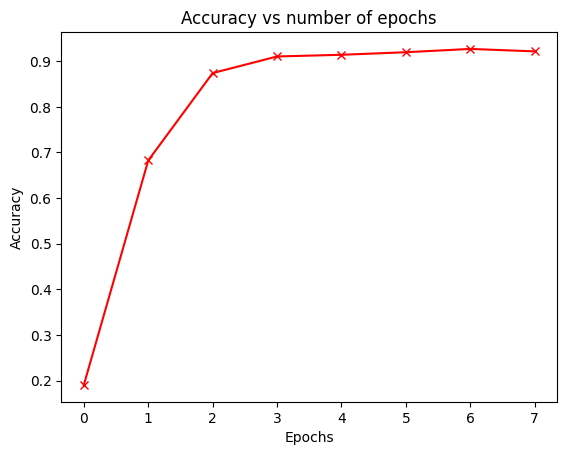

In [22]:
accuracy = [x["val_acc"] for x in history]
plt.plot(accuracy, "-rx")
plt.title("Accuracy vs number of epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Text(0.5, 0, 'Epochs')

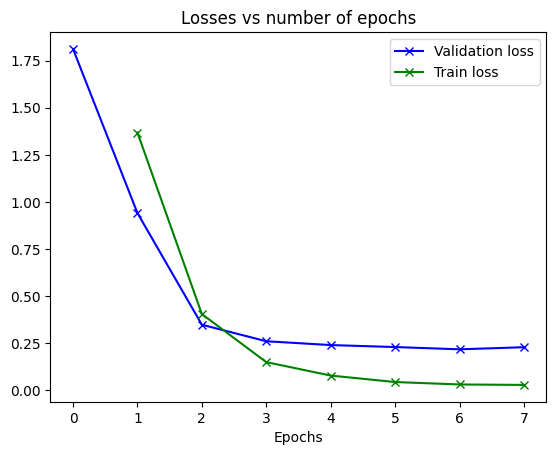

In [23]:
val_loss = [x["val_loss"] for x in history]
train_loss = [x.get("train_loss") for x in history]
plt.plot(val_loss, "-bx")
plt.plot(train_loss, "-gx")
plt.title("Losses vs number of epochs")
plt.legend(["Validation loss", "Train loss"])
plt.xlabel("Epochs")

In [28]:
acc_temp =0
for i in range(1000):
  images, labels = test_ds[i]
  if test_ds.classes[labels]== prediction(model, images):
    acc_temp=acc_temp+1
  
  
acc1 = acc_temp/1000

In [29]:
acc1

0.94

In [22]:
model.freeze()

In [23]:
epochs = 7
max_lr = 10e-5
grad_clip = 0.1
weight_decay = 10e-4
opt_func = torch.optim.Adam

In [24]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                        weight_decay=weight_decay, grad_clip=grad_clip,
                        opt_func=opt_func)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: [1/7], last_lr: 0.000047, train_loss: 1.7429, val_loss: 1.7041, val_acc: 0.2284


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: [2/7], last_lr: 0.000099, train_loss: 1.6417, val_loss: 1.6367, val_acc: 0.2640


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: [3/7], last_lr: 0.000092, train_loss: 1.5159, val_loss: 1.5248, val_acc: 0.3300


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: [4/7], last_lr: 0.000067, train_loss: 1.4055, val_loss: 1.4479, val_acc: 0.3954


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: [5/7], last_lr: 0.000036, train_loss: 1.3335, val_loss: 1.4033, val_acc: 0.4302


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: [6/7], last_lr: 0.000010, train_loss: 1.3055, val_loss: 1.3898, val_acc: 0.4382


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: [7/7], last_lr: 0.000000, train_loss: 1.2921, val_loss: 1.3804, val_acc: 0.4434


Text(0, 0.5, 'Accuracy')

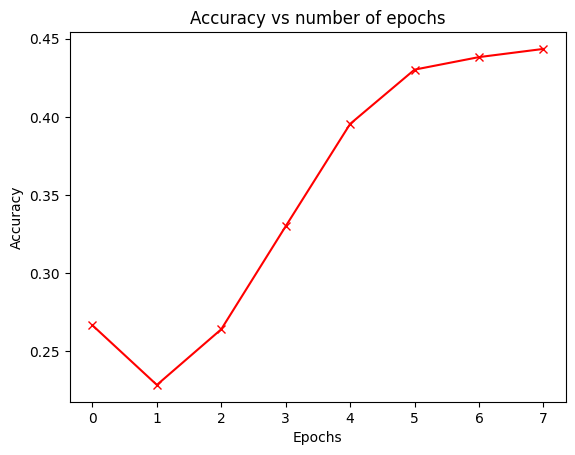

In [25]:
accuracy = [x["val_acc"] for x in history]
plt.plot(accuracy, "-rx")
plt.title("Accuracy vs number of epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Text(0.5, 0, 'Epochs')

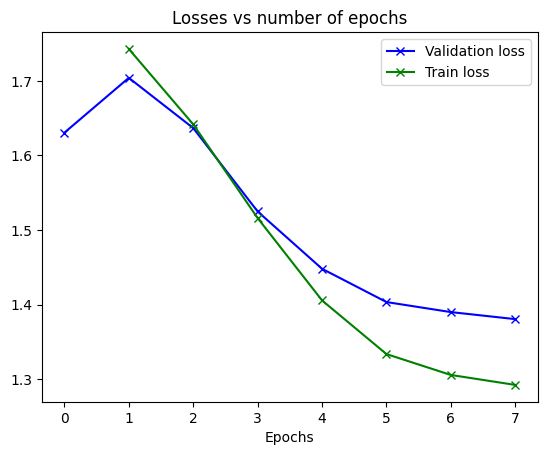

In [26]:
val_loss = [x["val_loss"] for x in history]
train_loss = [x.get("train_loss") for x in history]
plt.plot(val_loss, "-bx")
plt.plot(train_loss, "-gx")
plt.title("Losses vs number of epochs")
plt.legend(["Validation loss", "Train loss"])
plt.xlabel("Epochs")

In [36]:
acc_temp =0
for i in range(1000):
  images, labels = test_ds[i]
  if test_ds.classes[labels]== prediction(model, images):
    acc_temp=acc_temp+1
  
  
acc = acc_temp/1000

In [37]:
acc

0.43